### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import vstack, hstack
from collections import defaultdict
from scipy.stats import poisson
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, Matern

### Customer Simulation

The number of customers coming to a market can be described as a Poisson distribution. The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values).

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In the formula above, y is the number of customers coming to the market, $ \lambda $ is expectations of the customer number in a given time period. 


Besides, the other hyper-parameters, such as the opening hours, are also set here.

In [2]:
opentime = 9
closetime = 18
timeline =  defaultdict(list)
booking = []
p = np.array([45,60,80,110,120,110,80,50,40])   # lamda for randomg arrving customer
p_b = np.array([20,20,25,30,40,25,30,25,20]) # lamda for booking customer
for i in range(opentime,closetime):
    simu = poisson.rvs(p[i-opentime],size=20)
    timeline[i] = simu  
    booking.append(poisson.rvs(p_b[i-opentime],size=20).mean())

### The results of simulation 

We generated customers coming to a market with/without booking; when the actual data is acquirable from infrared detectors in the market or the booking system, we can modify the input instead of using simulation data. We will achieve a better final model. 

With more and more data acquire, the model will learn sequentially. 

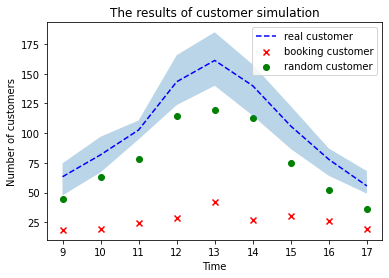

In [7]:
simu_listmean = []
simu_listMax = []
simu_listMin = []
# raw_data = []
for k,v in timeline.items():
    simu_listmean.append(np.array(v).mean())
    simu_listMax.append(np.array(v).max())
    simu_listMin.append(np.array(v).min())
#     raw_data.append(np.array(v))
    
x_plot = np.arange(opentime,closetime)
real_customer = np.array(simu_listmean)+np.array(booking)

plt.plot(x_plot,real_customer, linestyle='dashed',c = 'b', label = 'real customer')
plt.scatter(x_plot, booking, color='r', marker='x',label = 'booking customer')
plt.scatter(x_plot, simu_listmean, color='g', marker='o',label = 'random customer')

plt.fill_between(x_plot,np.array(booking)+np.array(simu_listMax),np.array(booking)+np.array(simu_listMin), alpha=0.3)
plt.title('The results of customer simulation')
plt.xlabel('Time')
plt.ylabel('Number of customers')
plt.legend()
plt.show()

### Gaussian Process Regression (prediction) model 

Based on the real-time number of customers detected from infrared detectors at the current time and booking situation, we can estimate the load for the rest of the time in a day. When customers can see the prediction results, they can arrange their time to avoid the queue and have a safe shopping trip.

In [11]:
def generator_data_for_a_day(p= np.array([45,60,80,110,120,110,80,50,40]), p_b = np.array([20,20,25,30,40,25,30,25,20]), w = False):
    # generator 9 points for training
    # lamda for randomg arrving customer
    # lamda for booking customer
    flag = 0
    timeline =  []
    booking = []
    for i in range(opentime, closetime):
        simu = poisson.rvs(p[i-opentime],size=20)
        timeline.append(simu.mean() + np.random.normal(0, 5, 1)[0])
        booking.append(poisson.rvs(p_b[i-opentime],size=20).mean() + np.random.normal(0, 3, 1)[0])
    timeline_final =np.zeros(closetime - opentime)
    flag = np.zeros(closetime - opentime)
    timeline_final[1:] = timeline[:-1]
    if w ==True:
        flag = np.ones(closetime - opentime)
    X = np.array([x_plot,timeline_final,booking]).T
    y = np.array(timeline)#+np.array(booking)
    return X,y

In [9]:
coef_weekend = 1 + 0.35 * np.random.rand(closetime - opentime)
p_merchants = {'A': np.array([15,18,23,30,32,28,20,17,13]),
                        'B': np.array([45,60,80,110,120,110,80,50,40]),
                        'C': np.array([55,75,90,135,160,130,102,80,45])}
p_b_merchants = {'A': np.array([7,6,7,8,11,6,8,9,7]),
                            'B': np.array([20,20,25,30,40,25,30,25,20]),
                            'C': np.array([24,25,28,37,53,30,38,40,23])}
capacity = {'A': 30,
                  'B': 120,
                  'C': 160}
train_X = {}
train_y = {}
test_X = {}
test_y = {}
models = {}
preds_y_mean = {}
preds_y_cov = {}
rmse = {}
preds_y_ub = {}
preds_y_lb = {}
train_number_weeks = 50
test_number_weeks = 10
merchants = p_merchants.keys()

In [13]:
for merchant in merchants:
    train_X[merchant], train_y[merchant] =  generator_data_for_a_day(p_merchants[merchant], p_b_merchants[merchant])
    test_X[merchant], test_y[merchant] =  generator_data_for_a_day(p_merchants[merchant], p_b_merchants[merchant])
    for week in range(train_number_weeks):
        for _ in range(5):
            X_new, y_new = generator_data_for_a_day(p_merchants[merchant], p_b_merchants[merchant])
            train_X[merchant] = vstack((train_X[merchant], X_new))
            train_y[merchant] = hstack((train_y[merchant], y_new))
        for _ in range(2):
            X_new, y_new = generator_data_for_a_day(coef_weekend*p_merchants[merchant], coef_weekend*p_b_merchants[merchant], w = True)
            train_X[merchant] = vstack((train_X[merchant], X_new))
            train_y[merchant] = hstack((train_y[merchant], y_new))
#     print(train_X[merchant].shape,train_y[merchant].shape)

    for week in range(test_number_weeks):
        for _ in range(5):
            X_new, y_new = generator_data_for_a_day(p_merchants[merchant], p_b_merchants[merchant])
            test_X[merchant] = vstack((test_X[merchant], X_new))
            test_y[merchant] = hstack((test_y[merchant], y_new))
        for _ in range(2):
            X_new, y_new = generator_data_for_a_day(coef_weekend*p_merchants[merchant], coef_weekend*p_b_merchants[merchant], w = True)
            test_X[merchant] = vstack((test_X[merchant], X_new))
            test_y[merchant] = hstack((test_y[merchant], y_new))
#     print(test_X[merchant].shape,test_y[merchant].shape)
for merchant in merchants:
    kernel = Matern()
    # kernel = ExpSineSquared(length_scale=1, periodicity=1)
    # kernel = RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))
    # gpr = GaussianProcessRegressor(kernel=kernel, alpha=5,
    #         random_state=0).fit(X, y)

    models[merchant] = GaussianProcessRegressor(kernel = kernel, alpha = 0.1)
    models[merchant].fit(train_X[merchant], train_y[merchant])

    preds_y_mean[merchant], preds_y_cov[merchant] = models[merchant].predict(test_X[merchant], return_cov=True)
    rmse[merchant] = (((preds_y_mean[merchant] - test_y[merchant])**2).mean())**0.5
#     print('prediction_'+merchant+':', preds_y_mean[merchant])
#     print('ground truth_'+merchant+':', test_y[merchant])
    print('rmse_'+merchant+':', rmse[merchant])

rmse_A: 7.1059741296016306
rmse_B: 7.253932445965281
rmse_C: 7.089243789330552


### plotting functions

In [95]:
def plot_preds_errbar(test_X, test_y, preds_y, preds_y_ub, preds_y_lb, xlabel, ylim, xaxis_format = False):
    text_X = np.array(test_X)
    test_y = np.array(test_y)
    preds_y = np.array(preds_y)
    preds_y_ub = np.array(preds_y_ub)
    preds_y_lb = np.array(preds_y_lb)
    
    fig, ax = plt.subplots()
    ax.plot(test_X, test_y, 'b--', label = 'Ground truth')
    ax.plot(test_X, preds_y, 'r-', label = 'Predictions')
    ax.fill_between(test_X, preds_y_ub, preds_y_lb, color = 'k', label='$\pm\sigma$ error bars', alpha = 0.3)
    relative_acc = 1 - abs(preds_y - test_y)/test_y
    for a,b,c in zip(test_X, preds_y, relative_acc):        
        plt.text(a, b+0.5, '''{:.0%}'''.format(c) , ha='center', va= 'bottom', fontsize=11, label = 'Relative accuracy')
    if xaxis_format == True:
        ax.xaxis.set_major_formatter('{x:.0f}:00')
    plt.ylim(ylim[merchant])
    plt.title('Shop {}'.format(merchant))
    plt.xlabel(xlabel)
    plt.ylabel('Number of customers inside the shop')
    plt.rcParams['figure.dpi'] = 300
    plt.legend()
    plt.show()

In [96]:
def plot_color_bar(plot_X,plot_Y, xlabel, capacity = 30, xaxis_format = False):
    plot_X = np.array(plot_X)
    plot_Y = np.array([value if value <= capacity else capacity for value in plot_Y])
    
    fig, ax = plt.subplots()
    percentage = plot_Y / capacity
    colour_list = np.ones(shape=len(plot_Y))
    colour_list[np.argwhere(plot_Y / capacity  > 0.9)] = 2
    colour_list[np.argwhere(plot_Y / capacity  < 0.7)] = 0
    colour_list = list(colour_list)
    colour_list = ['green' if colour_list[i] == 0 else 'orange' if colour_list[i] == 1 else 'red' for i in range(len((colour_list)))]
    plt.bar(plot_X, plot_Y, color= colour_list,alpha=0.6)
    for a,b,c in zip(plot_X,plot_Y,percentage):        
        plt.text(a, b+0.05, '''{:.0%}'''.format(c) , ha='center', va= 'bottom', fontsize=11, label = 'Percentage of capacity')
    if xaxis_format == True:
        ax.xaxis.set_major_formatter('{x:.0f}:00')
    plt.ylim([0, 1.2*capacity])
    plt.title('Shop {}'.format(merchant))
    plt.xlabel(xlabel)
    plt.ylabel('Number of customers inside the shop')
    plt.rcParams['figure.dpi'] = 300

### Overall results of prediction and Examples.

We initialize the system with three supermarkets of different sizes and build models for them. We can access any results once we have historical data, and the following results are based on simulation. 

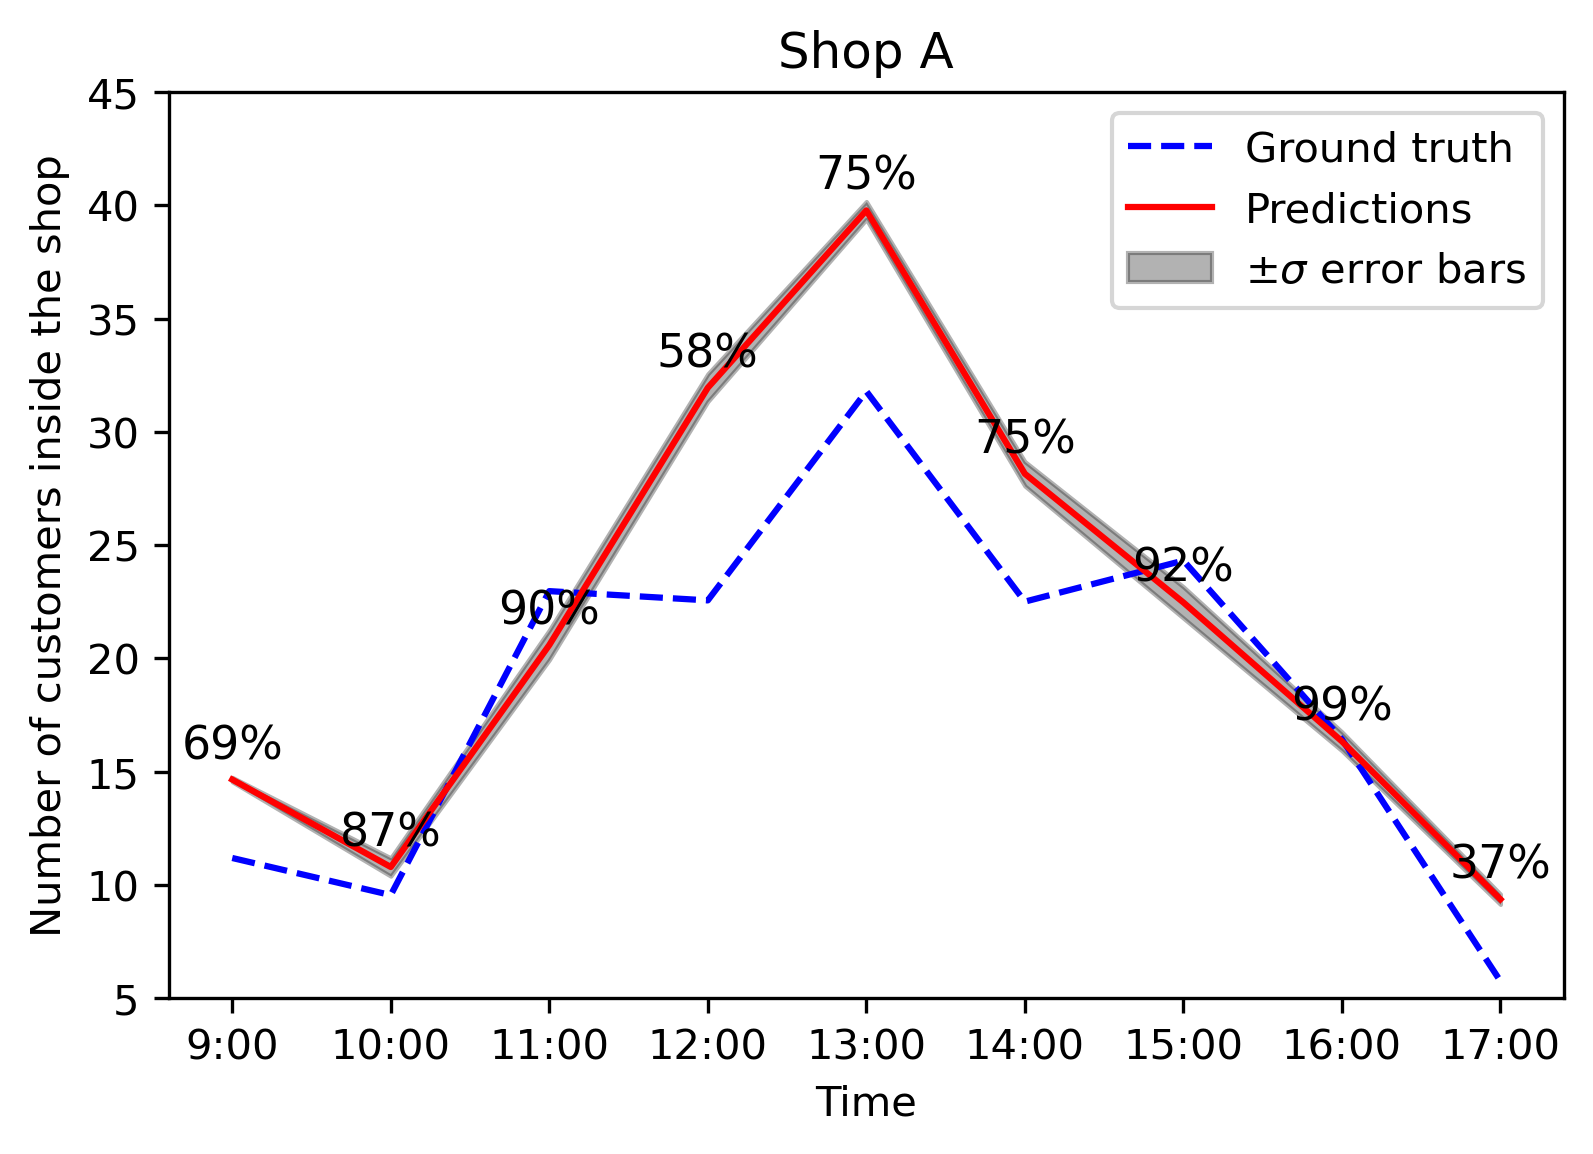

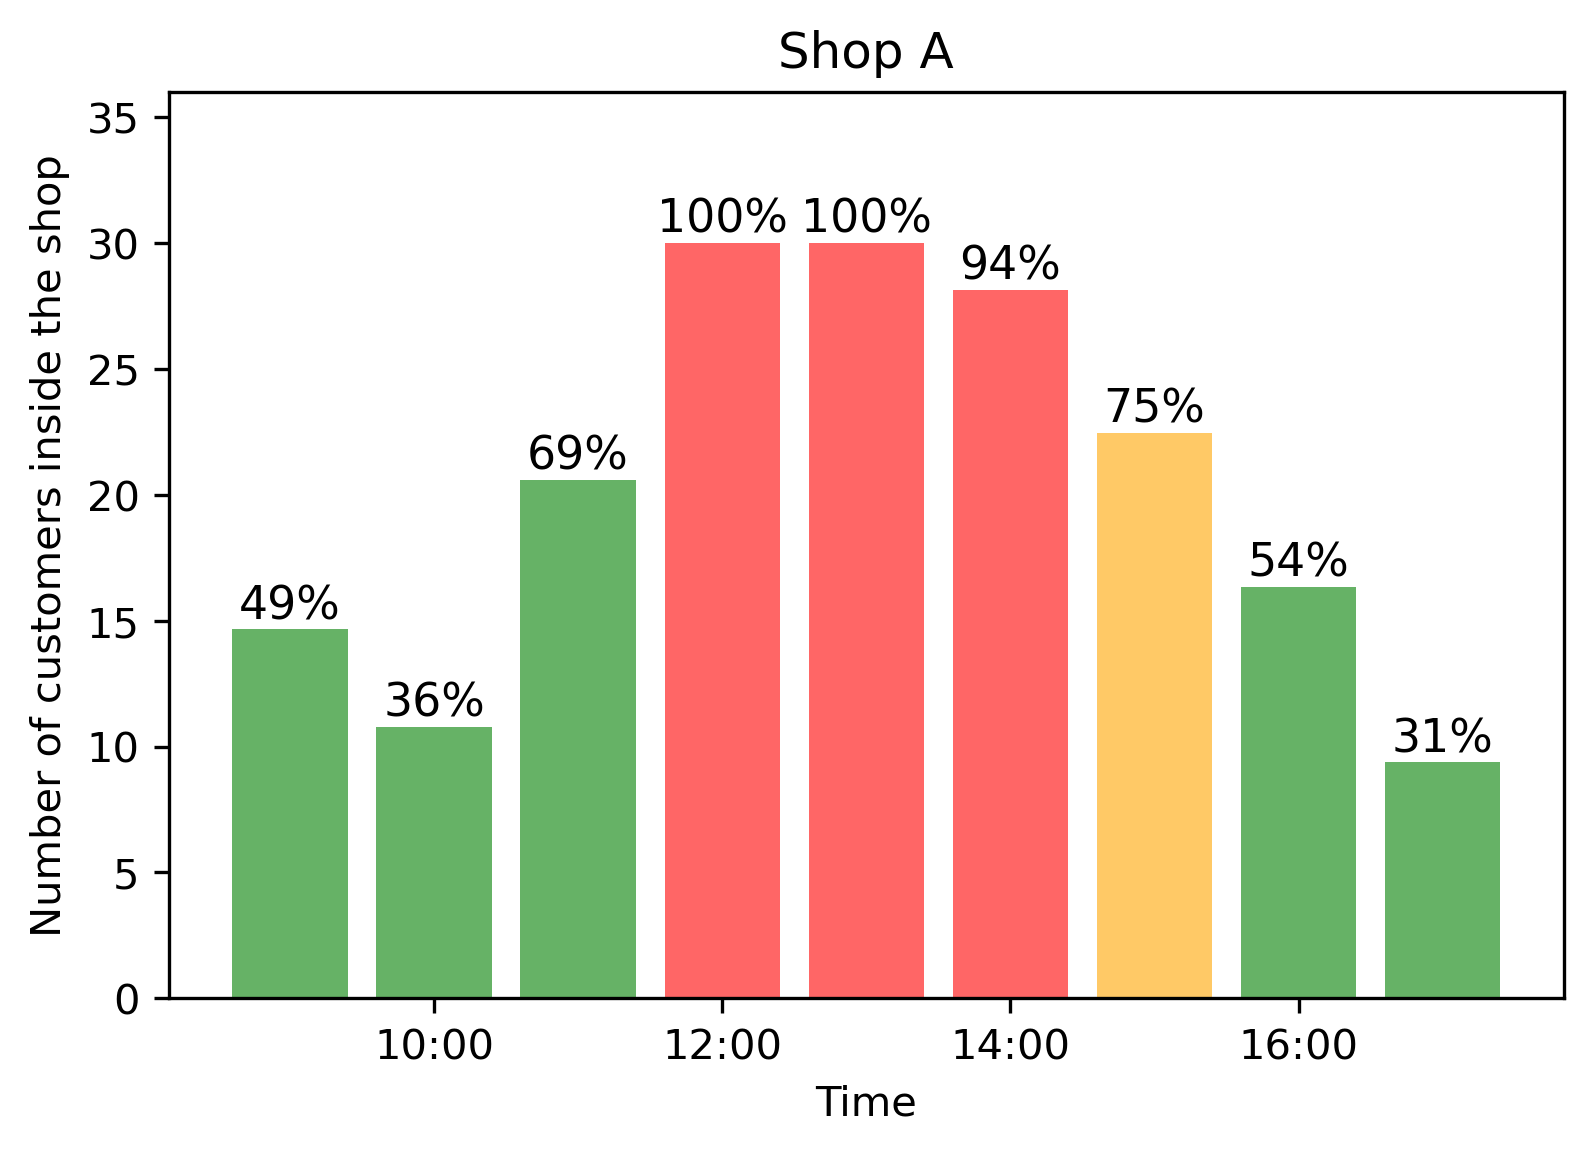

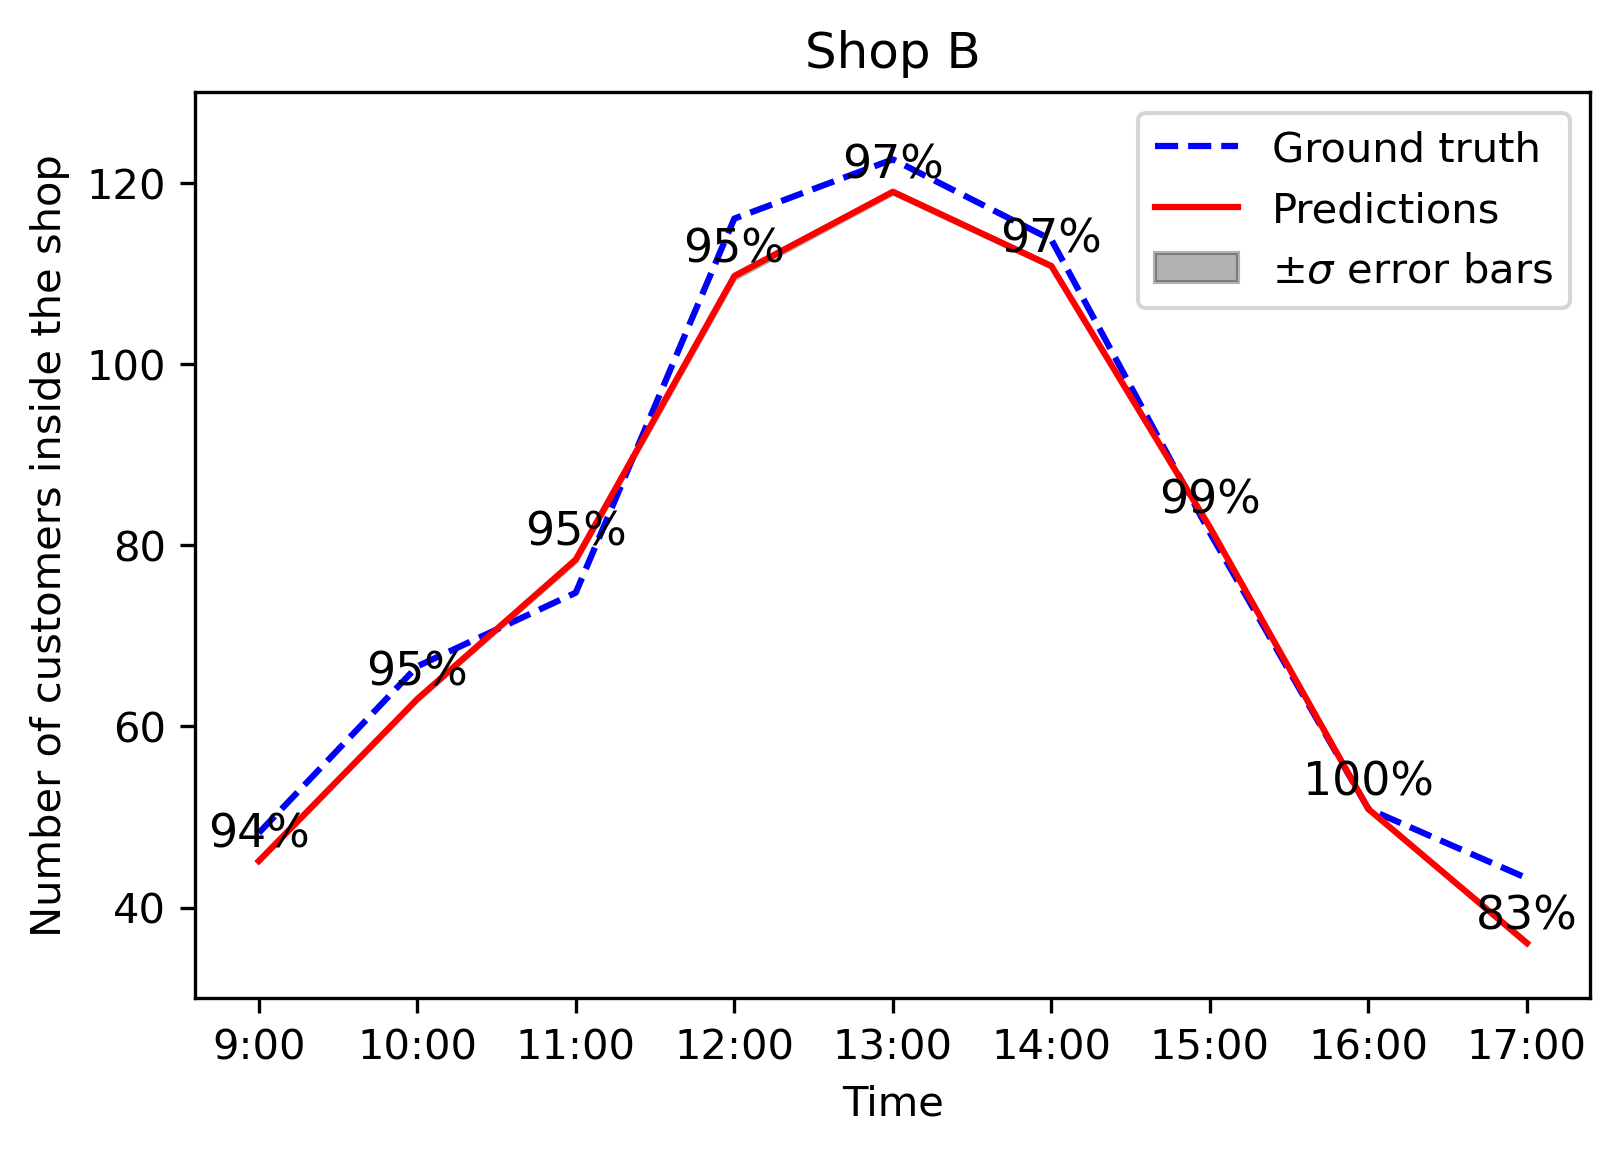

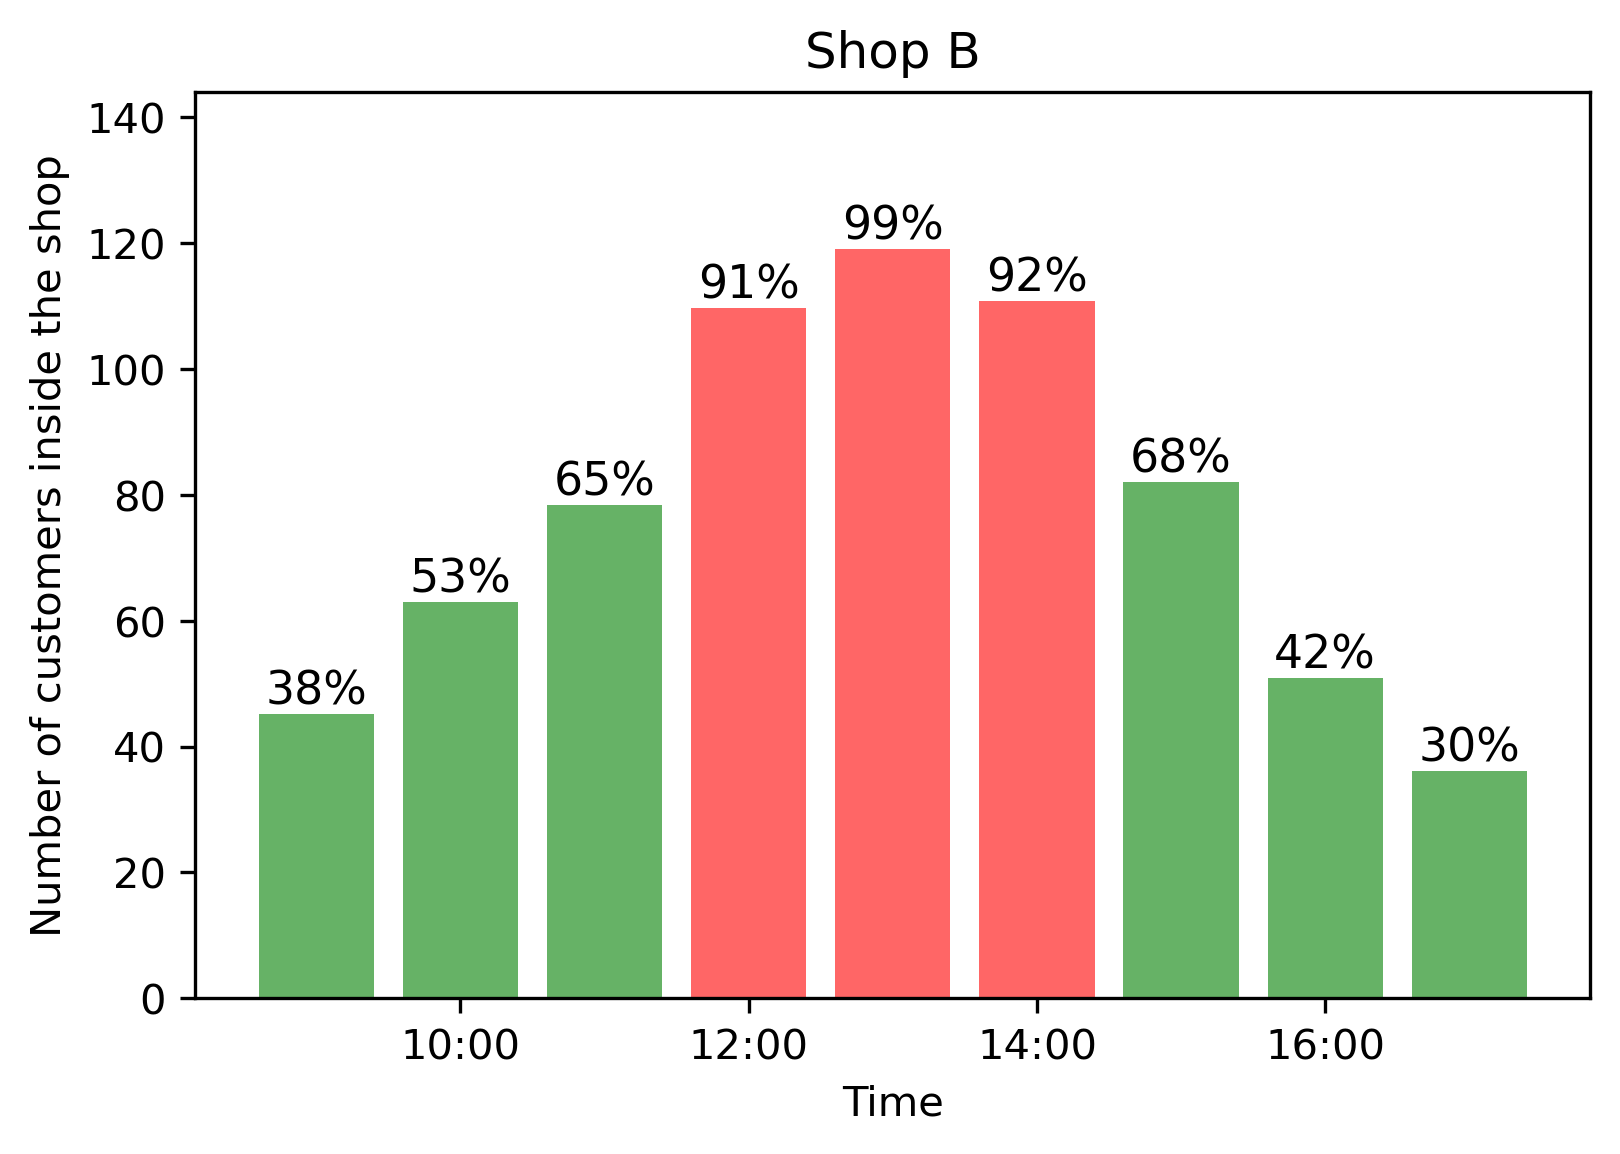

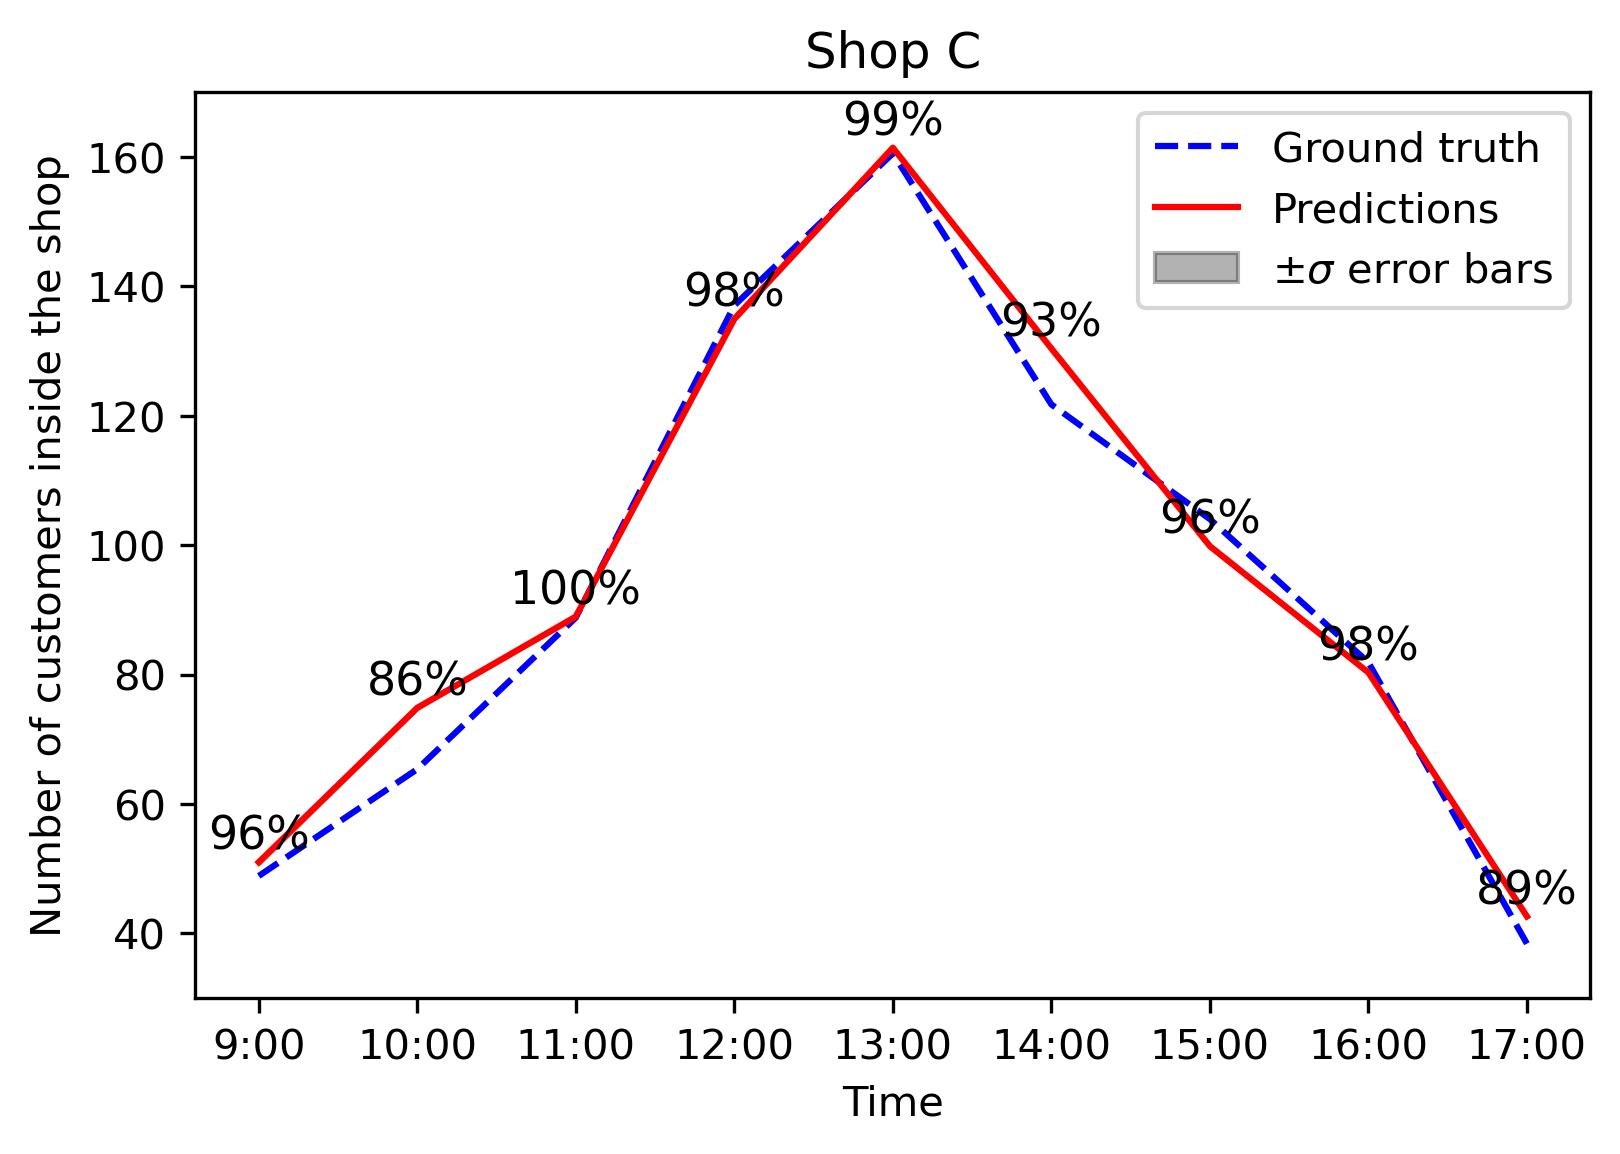

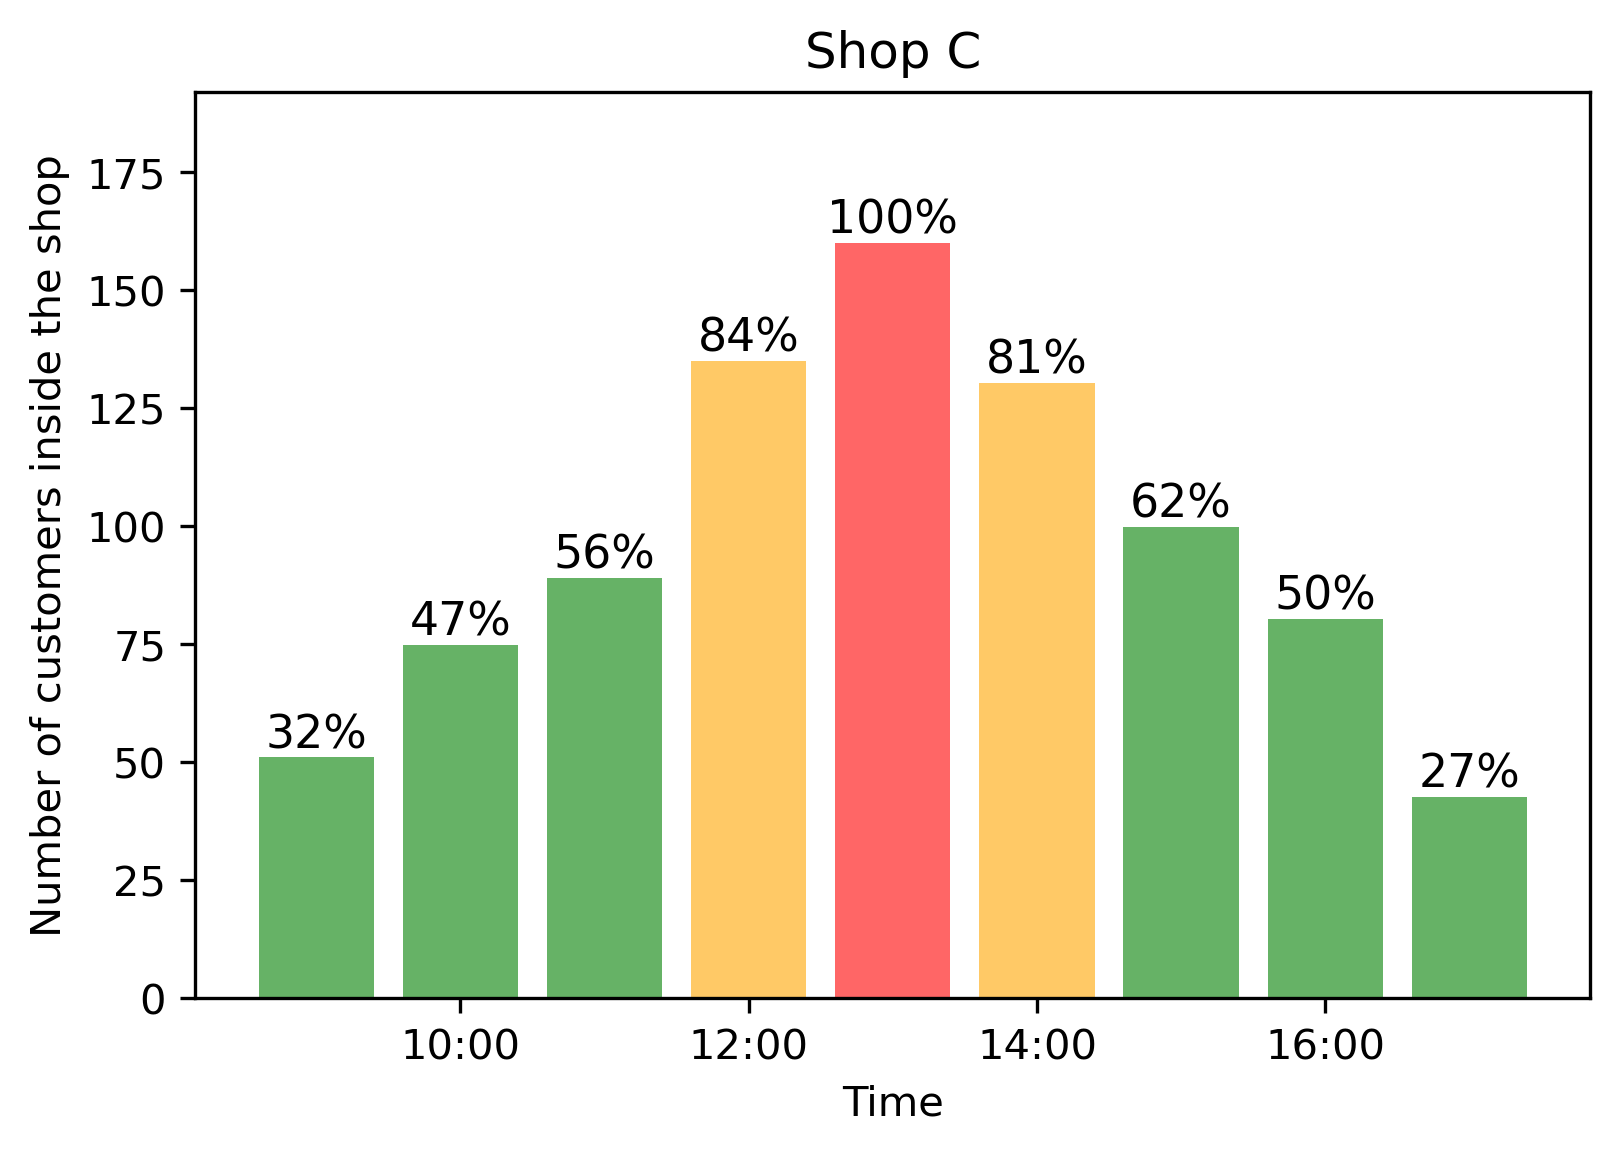

In [98]:
ylim0 = {'A': [5, 45],
             'B': [30, 130],
             'C': [30, 170]}
ylim1 = {'A': [15, 35],
             'B': [60, 110],
             'C': [80, 140]}
xlabel0 = 'Time'
xlabel1 = 'Index'
for merchant in merchants:
    X = range(opentime, closetime)
    preds_y_ub[merchant] = preds_y_mean[merchant] + np.sqrt(np.diag(preds_y_cov[merchant]))
    preds_y_lb[merchant] = preds_y_mean[merchant] - np.sqrt(np.diag(preds_y_cov[merchant]))

    plot_preds_errbar(X, test_y[merchant][:9], preds_y_mean[merchant][:9], preds_y_ub[merchant][:9], preds_y_lb[merchant][:9], xlabel0, ylim0, xaxis_format = True)
    plot_color_bar(X, preds_y_mean[merchant][:9], xlabel0, capacity = capacity[merchant], xaxis_format = True)

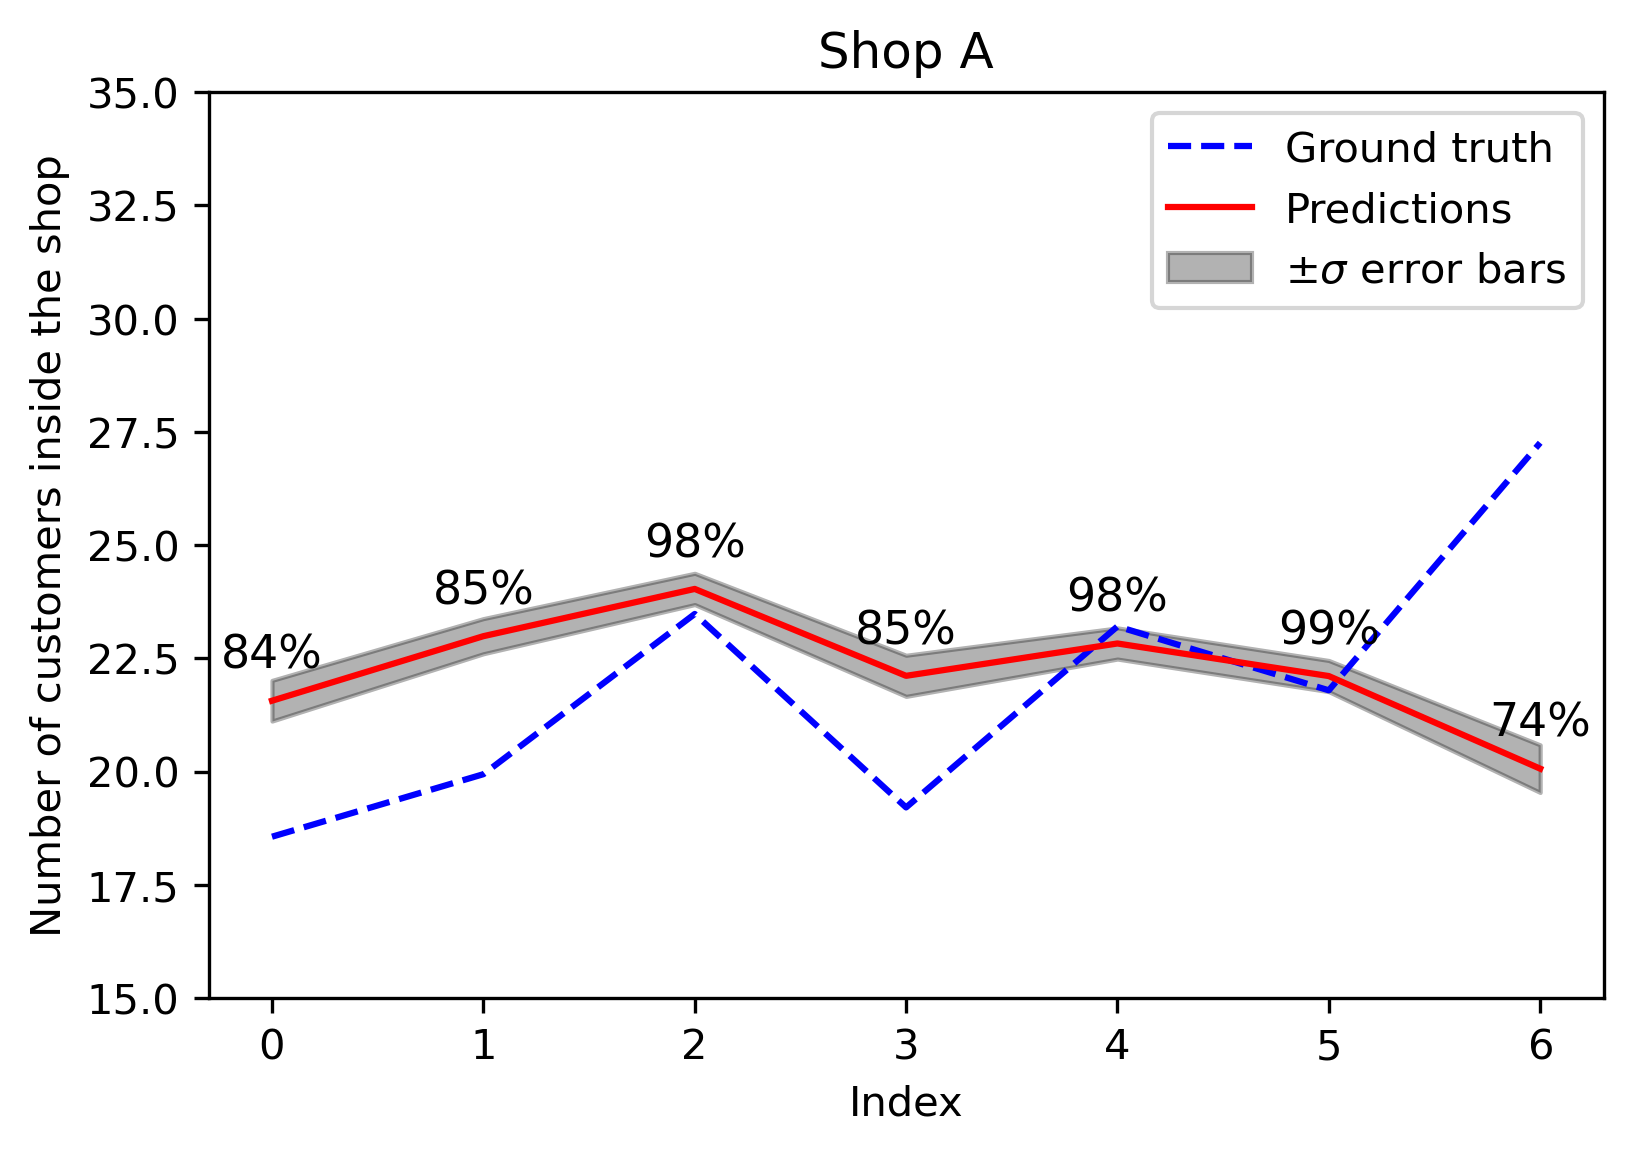

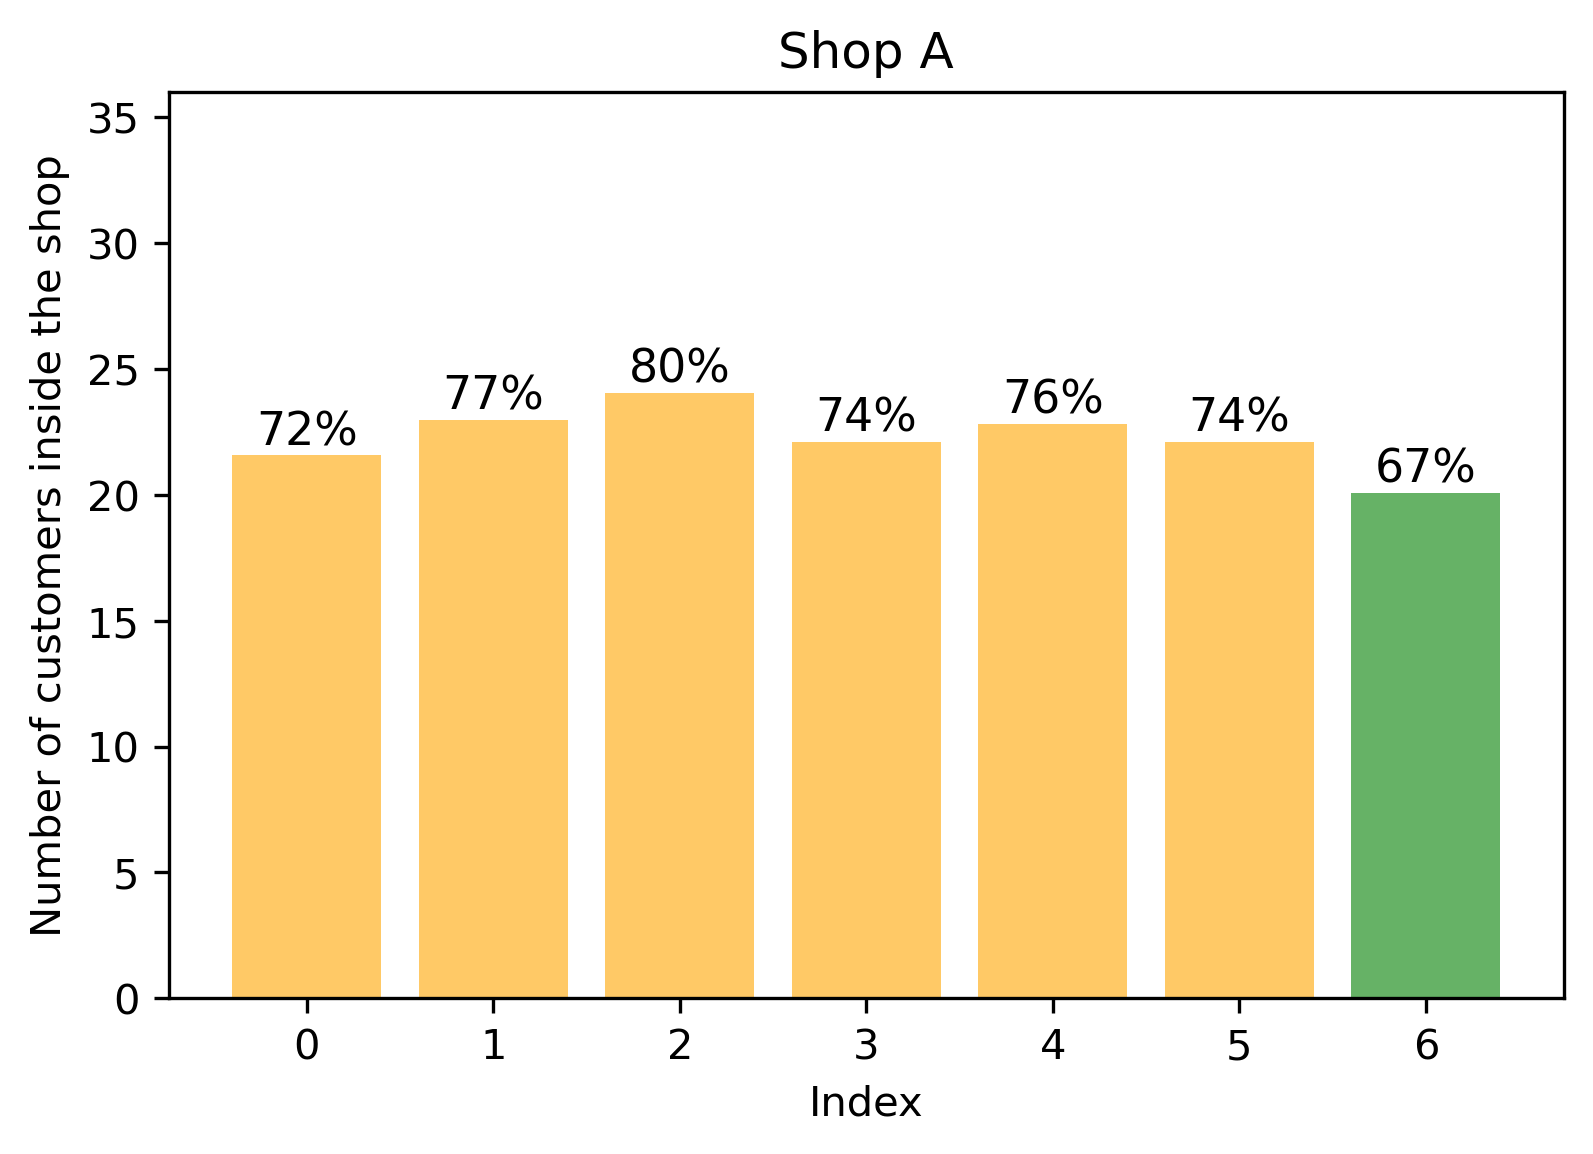

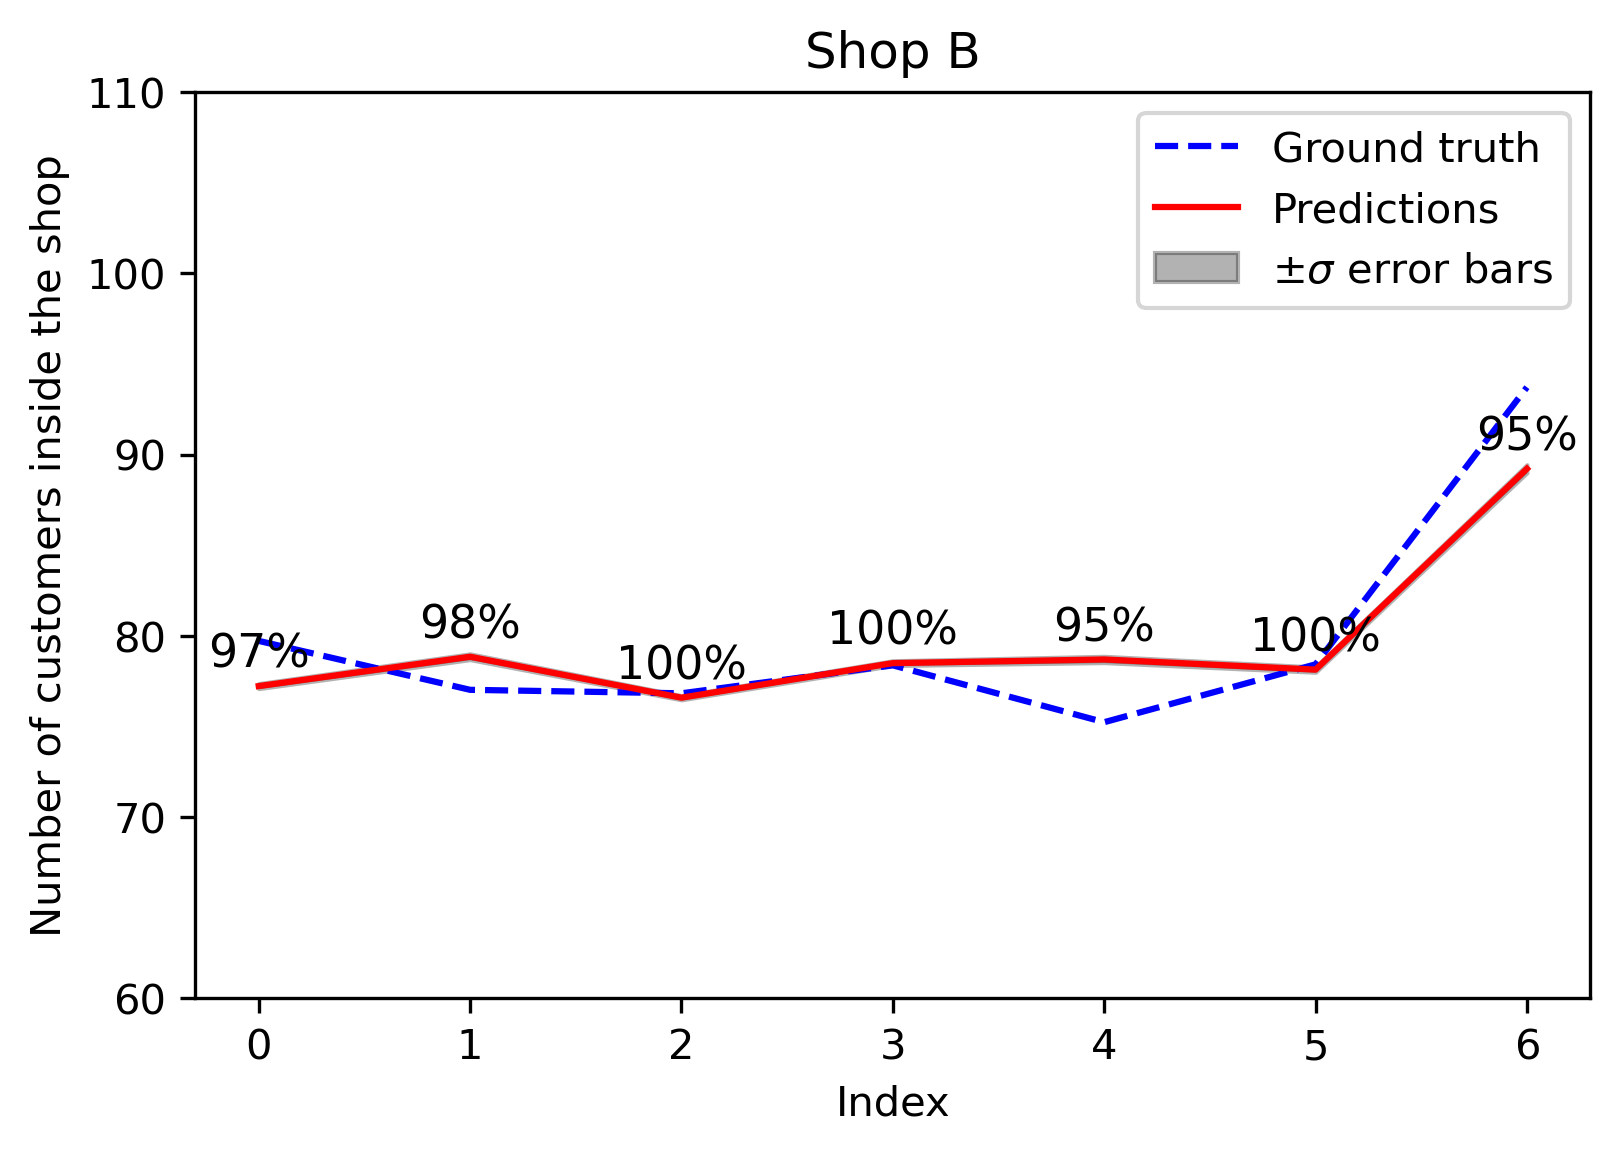

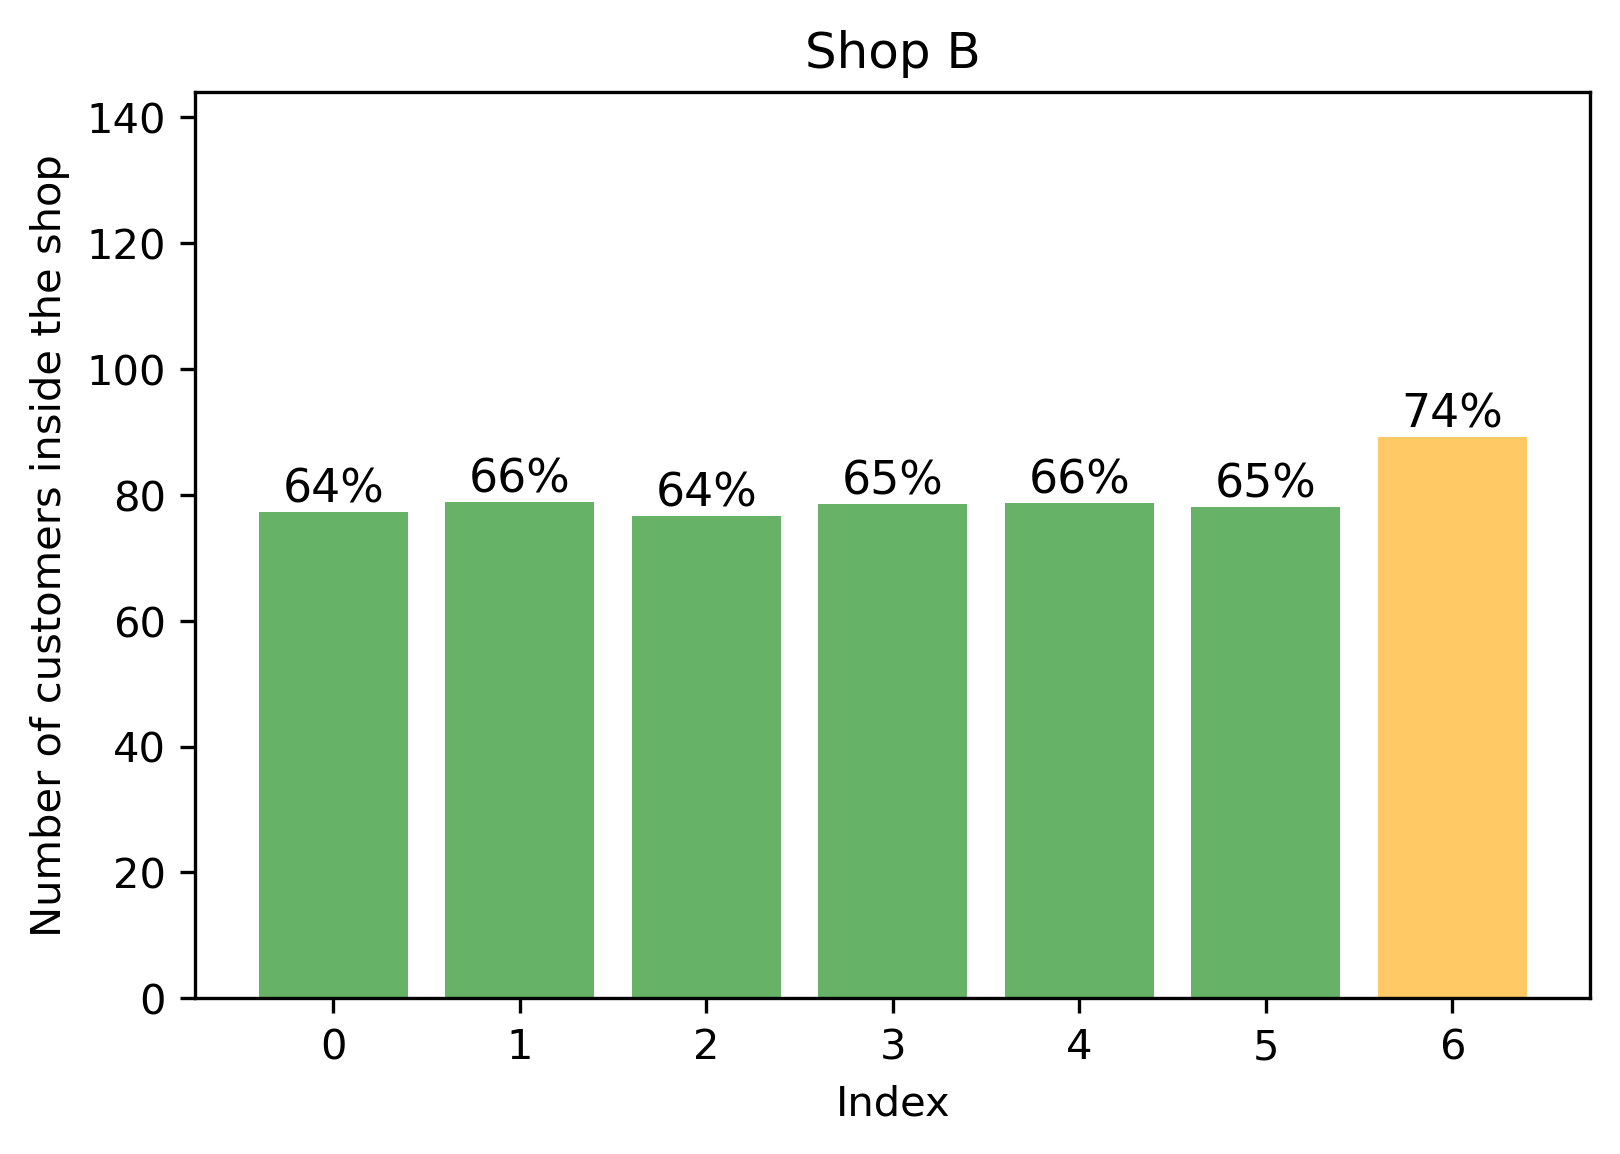

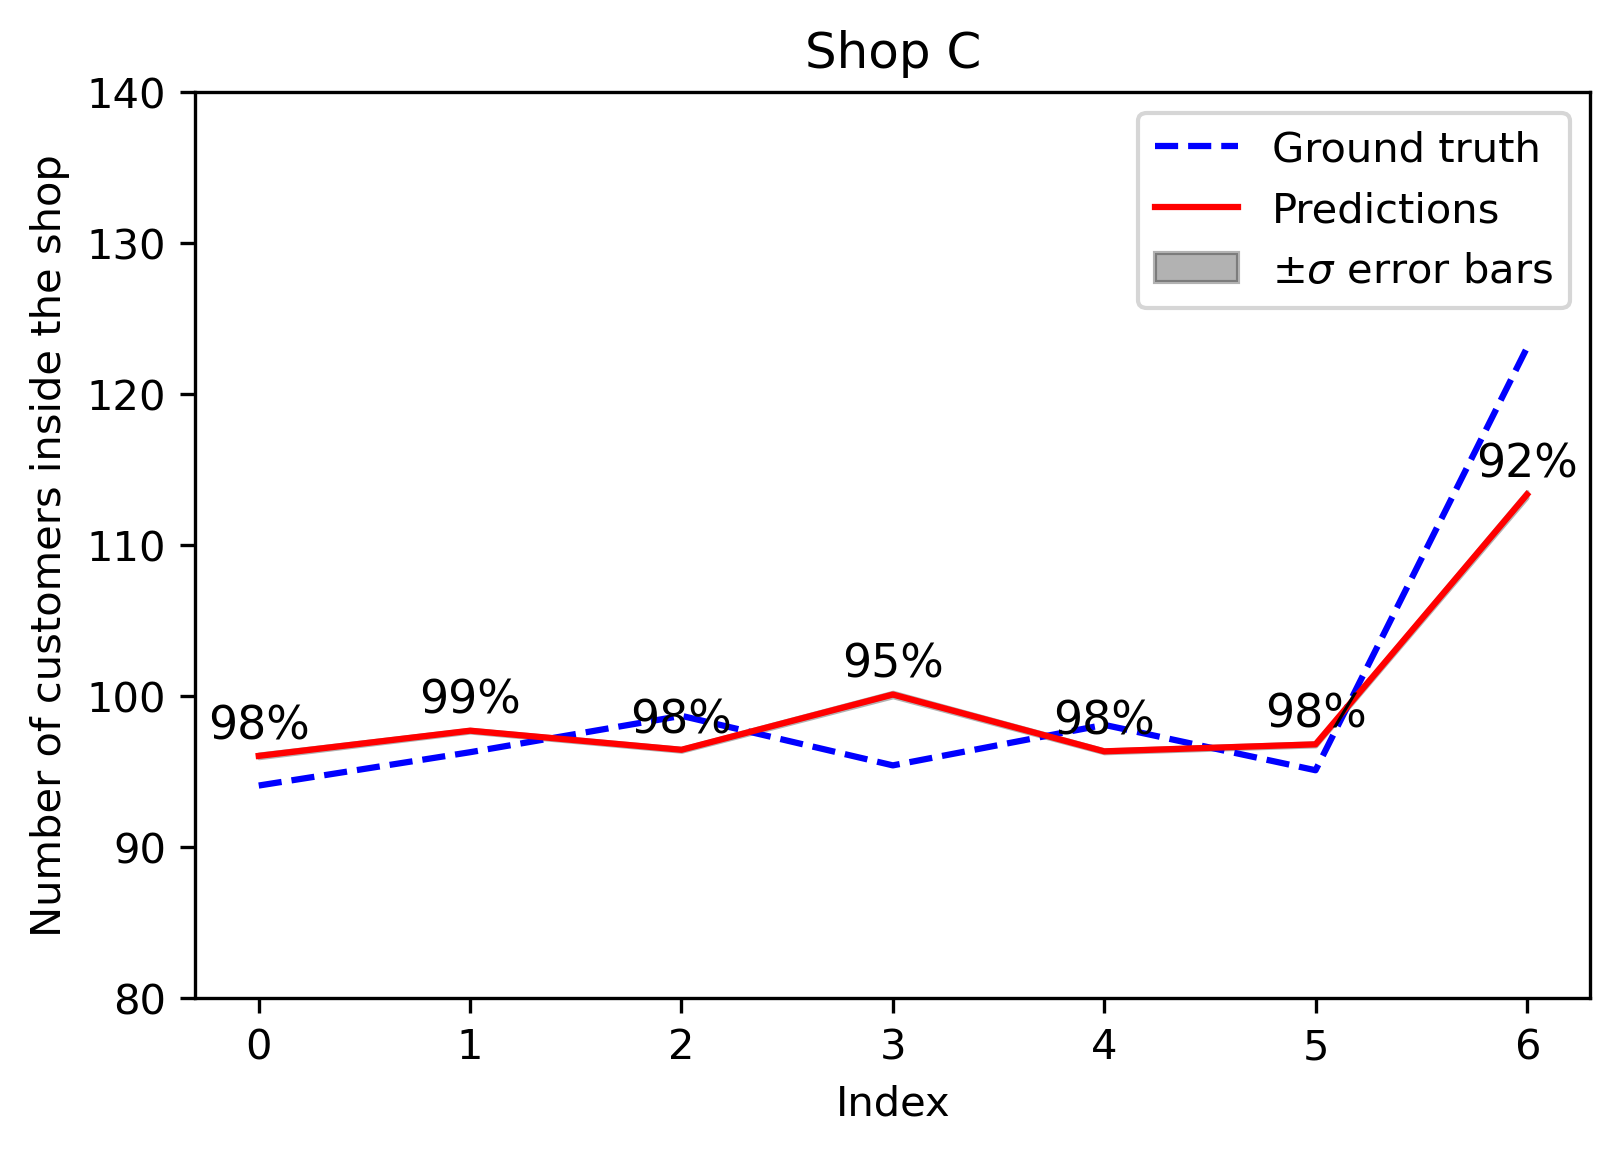

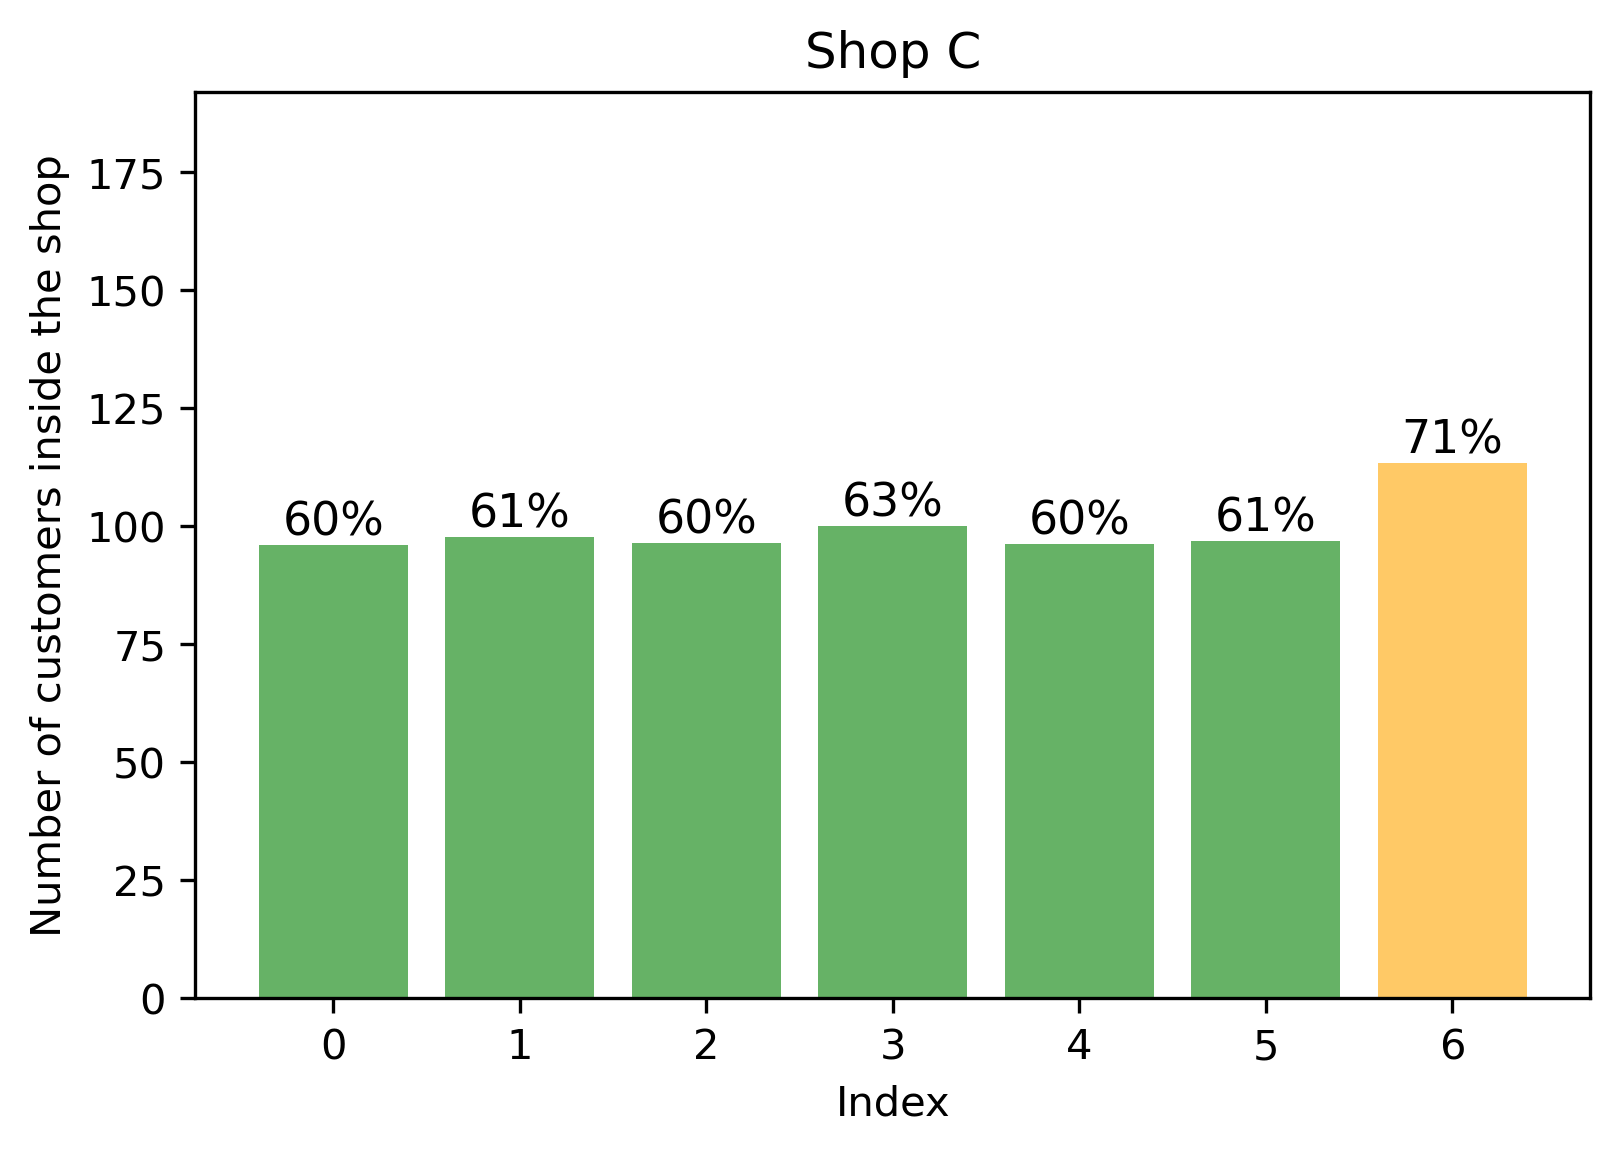

In [99]:
for merchant in merchants:
    smooth_X = list(range(0, int(len(test_X[merchant])/(closetime - opentime))))
    smooth_test_y = []
    smooth_y_mean = []
    smooth_y_ub = []
    smooth_y_lb = []
    for i in range(0, len(test_X[merchant])):
        if i % (closetime - opentime) == 0:
            smooth_test_y.append(test_y[merchant][i : i + closetime - opentime].mean())
            smooth_y_mean.append(preds_y_mean[merchant][i : i + closetime - opentime].mean())
            smooth_y_ub.append(preds_y_ub[merchant][i : i + closetime - opentime].mean())
            smooth_y_lb.append(preds_y_lb[merchant][i : i + closetime - opentime].mean())

    plot_preds_errbar(smooth_X[:7], smooth_test_y[:7], smooth_y_mean[:7], smooth_y_ub[:7], smooth_y_lb[:7], xlabel1, ylim1)
    plot_color_bar(smooth_X[:7], smooth_y_mean[:7], xlabel1, capacity = capacity[merchant])